# Stock market predictions from Reddit WorldNews Channel titlelines

## Fundamentals of Data Science - Final Project

| Group Member         | Student ID  | Istitutional Email                   |
| -------------------- | ----------- | -------------------------------------|
| Andrea Messina       | 2052125     | messina.2052125@studenti.uniroma1.it |
| Leonardo Di Nino     | 1919479     | dinino.1919479@studenti.uniroma1.it  |
| Adil Atahan Atik     | 2051413     | adilatahanatik@gmail.com             |
| Borbála Sára Tóth Gy | 2066306     | tothgy.2066306@studenti.uniroma1.it  |
| Maria Alejandra Peña | 2056718     | maria229724@gmail.com                |

### 0. Introduction

A relationship between breaking news and the stock price has been demonstrated. When breaking news arrives, stock prices will react. This is called Price Discovery.
The type of stock price reaction depends on whether the news is good, bad, or neutral. For investors it is important to have a model that helps them predict how much the market price varies depending on the type of news <sup>[1]</sup>.

The task of our project is to build a binary text classification model that is able to predict wheter the Dow Jones index is closing positively on negatively with respect to some news titlelines. 

The dataset we used was found on Kaggle at this link: https://www.kaggle.com/datasets/aaron7sun/stocknews.
Three tables can be found in this dataset:
- `RedditNews.csv`          -> This table contains two columns, one for the date and one for the news titlelines
- `upload_DJIA_table.csv`   -> This table contains financial information about Dow Jones Industrial Average: the `close` column was the one of interest.
- `Combined_News_DJIA.csv`  -> This table merges along the column `date` the news and a label that tells us wheter if that day the Dow Jones raised or dropped.

The range considered for these channels of data is from 2008-06-08 to 2016-07-01.

Our approach was to build several models, trying to figure out which one worked the best for our purpose, comparing our results with some state-of-art similar works. In particular, the division of the work is as follow:

- **Leonardo** did the data cleaning, the exploratory data analysis, the text-preprocessing and the feature engineering. Then he made some experiments in PyTorch framework with a fully connected neural network. 
- **Maria** worked on sentiment analysis through some tools and libraries, defining a Linear Discriminant Analysis model.
- **Andrea, Bori and Atik** worked on Naive Bayes classifier, implementing it from scratch and then comparing it with scikit learn already implemented.
- Everyone gathered scores and metrics from their models.

These are the libraries and modules we needed through the whole project.

In [ ]:
import pandas as pd                                                     #Data scientist starter pack
import numpy as np
from matplotlib import pyplot as plt
import math

from collections import Counter                                         #Some useful tools 
from functools import reduce

import seaborn as sns                                                   #More on plotting

import torch as trc                                                     #To set PyTorch framework
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Module
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as func

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    #Import LDA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import train_test_split                    #Tool to fast build validation set
from sklearn.naive_bayes import BernoulliNB                             #Naive Bayes classifier from scikit learn

from textblob import TextBlob                                           #TextBlob to do the subjectivity and polarily analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer    #VADER to obtain the sentiment score

from datetime import datetime                                           #To deal with datetime objects

import string                                                           #Some useful string tools
import nltk                                                             #Natural language processing libraries
import spacy
import re                                                               #Regex tools

import random as rdm                                                    #Simulation tools
import time                                                             #Ticking away the moments that make up a dull day

from tqdm import tqdm                                                   #Te quiero desmasiado 

This is a link for browser visualization through NBViewer: https://nbviewer.org/github/LeoDiNino97/FDS_final_project/blob/main/Project_report.ipynb

### 1. Setup

#### 1.1 The data pipeline

![Data pipeline](https://admhw3.s3.amazonaws.com/pipeline.jpg "Data pipeline")

#### 1.2 First data manipulation: Dow Jones explorative data analysis

We prefered to work on `RedditNews.csv` and `upload_DJIA_table.csv` tables rather than the already combined one. This made us figure out the relational logic behind this information pipeline and to build our own dataset. 

In [2]:
dow_jones = pd.read_csv('datasets/upload_DJIA_table.csv', usecols=['Date','Open','Close'])
dow_jones.head(10)

,Date,Open,Close
0,2016-07-01,17924.240234,17949.369141
1,2016-06-30,17712.759766,17929.990234
2,2016-06-29,17456.019531,17694.679688
3,2016-06-28,17190.509766,17409.720703
4,2016-06-27,17355.210938,17140.240234
5,2016-06-24,17946.630859,17400.750000
6,2016-06-23,17844.109375,18011.070312
7,2016-06-22,17832.669922,17780.830078
8,2016-06-21,17827.330078,17829.730469
9,2016-06-20,17736.869141,17804.869141


We can see that this table is really consistent:

In [3]:
dow_jones.isna().sum()

Date     0
Open     0
Close    0
dtype: int64

Now we are going to extract the ground-truth label:
- 1 express that the DJIA closed increasing over the opening value or at least remained the same;
- 0 express that the DJIA closed decreasing over the opening value.

In [4]:
ground_truth = []
for idx in dow_jones.index:
    try:
        if dow_jones.iloc[idx].Close >= dow_jones.iloc[idx+1].Close:
            ground_truth.append(1)
        else:
            ground_truth.append(0)
    except IndexError:
            ground_truth.append(0)

Then we are just inserting it into the Dow Jones table.

In [5]:
dow_jones['Label'] = ground_truth

As we can see the ground-truth is well balanced, so the risk of skewing towards a majority during the actual classification should be not so high. At the same time this is not a sufficient criterion to be sure that our models will perform well. Infact we have to consider also
- The distribution of the ground truth in the train-set and in the test-set: this can affect the precision and recall scores.
- The distribution of the features in the train-set and in the test-set: this can affect the whole training process and the overall accuracy score.

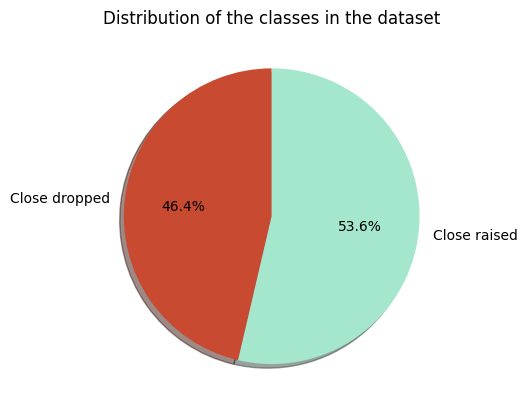

In [6]:
sizes = np.array([len(dow_jones[dow_jones['Label'] == 0]), len(dow_jones[dow_jones['Label'] == 1])])
sizes = sizes/len(dow_jones)

classes = ['Close dropped', 'Close raised']

ax = plt.subplot(111)
ax.pie(sizes, labels=classes,autopct='%1.1f%%',shadow=True, startangle=90, colors=['#C84B31','#A5E7CC'] )
plt.title('Distribution of the classes in the dataset')
plt.show()

#### 1.3 First data manipulation: Newstitles explorative data analysis and text preprocessing

In [7]:
news = pd.read_csv('datasets/RedditNews.csv')
news.head(10)

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
5,2016-07-01,Brazil: Huge spike in number of police killing...
6,2016-07-01,Austria's highest court annuls presidential el...
7,2016-07-01,"Facebook wins privacy case, can track any Belg..."
8,2016-07-01,Switzerland denies Muslim girls citizenship af...
9,2016-07-01,China kills millions of innocent meditators fo...


In [8]:
news.isna().sum()

Date    0
News    0
dtype: int64

The Newstitles dataset is also very consistent, so the explorative data analysis doesn't have to go any further. 

The most important step now is to preprocess the text, in order to make it more digestible for our following feature engineering. We follow the usual scheme for text preprocessing:
- Removal of punctuation and stop words;
- Tokenization of the text;
- Stemming of the words to reduce different forms of same word roots.

We also excluded words containing digits and words shorter than 3 characters to start dealing with the high dimensionality of the features we are going to extract. 

In [213]:
def text_preprocesser(text:string)->list:
    tokenized = nltk.word_tokenize(''.join([char 
                                       for char 
                                       in text.lower() 
                                       if char not in string.punctuation]))
                                       
    stop_words = nltk.corpus.stopwords.words('english')
    no_stop_words = [word 
                     for word 
                     in tokenized 
                     if word not in stop_words]

    stemmer = nltk.stem.porter.PorterStemmer()

    return [stemmer.stem(word)
            for word 
            in no_stop_words
            if any(chr.isdigit() for chr in word) == False and len(word) > 3]

This table contains for each date 25 title news, so we can easily group on the primary key to define in the end a one big document for each date.

In [214]:
documents = {}
for date in tqdm(news.Date.unique()):
    processed = []
    for text in news.News[news.Date == date]:
        processed += text_preprocesser(text)
    documents[date] = processed

100%|██████████| 2943/2943 [00:52<00:00, 55.60it/s]


This is a view on our brand new documents:

In [215]:
newers = pd.DataFrame({'Date':documents.keys(),
                      'Preprocessed News':documents.values()})
newers.head(10)

,Date,Preprocessed News
0,2016-07-01,"[woman, mexico, citi, final, receiv, birth, ce..."
1,2016-06-30,"[jamaica, propos, marijuana, dispens, tourist,..."
2,2016-06-29,"[explos, airport, istanbul, yemeni, former, pr..."
3,2016-06-28,"[scientist, australia, want, save, great, barr..."
4,2016-06-27,"[barclay, share, suspend, trade, tank, pope, s..."
5,2016-06-26,"[author, raid, scientolog, offic, russia, mone..."
6,2016-06-25,"[week, olymp, handl, drug, test, game, suspend..."
7,2016-06-24,"[david, cameron, resign, referendum, forecast,..."
8,2016-06-23,"[today, unit, kingdom, decid, whether, remain,..."
9,2016-06-22,"[german, govern, agre, frack, indefinit, teena..."


#### 1.4 Building up our dataset

Finally we make a natural join between our two tables, building the dataset we are going to use in the further steps of our work. 

In [216]:
final_dataset = dow_jones.merge(newers)
final_dataset = final_dataset.drop(labels=['Open','Close'], axis=1)
final_dataset.head(10)

,Date,Label,Preprocessed News
0,2016-07-01,1,"[woman, mexico, citi, final, receiv, birth, ce..."
1,2016-06-30,1,"[jamaica, propos, marijuana, dispens, tourist,..."
2,2016-06-29,1,"[explos, airport, istanbul, yemeni, former, pr..."
3,2016-06-28,1,"[scientist, australia, want, save, great, barr..."
4,2016-06-27,0,"[barclay, share, suspend, trade, tank, pope, s..."
5,2016-06-24,0,"[david, cameron, resign, referendum, forecast,..."
6,2016-06-23,1,"[today, unit, kingdom, decid, whether, remain,..."
7,2016-06-22,0,"[german, govern, agre, frack, indefinit, teena..."
8,2016-06-21,1,"[australian, athlet, compet, paralymp, game, r..."
9,2016-06-20,1,"[stagger, percent, venezuelan, money, enough, ..."


### 2. Feature engineering

#### 2.1 Text vectorization

The next step is to define a proper feature extraction for the preprocessed documents, because we need a vectorized version of the documents in order to make them a readable input for our classification models. 

We are dividing our feature engineering in two steps:
1) Extraction of `n-grams` and construction of the lexicon;
2) Vectorization of each documents with respect of a certain method and the just built lexicon. 

An n-gram is a feature structure gathered collecting groups of n subsequent words through the document. For example, if we want the 3-grams of the document **'Hello, my name is Leonardo'** we'll get {'Hello my name', 'my name is', 'name is Leonardo'}. In our case we used only 1-grams (the single words) and 2-grams. The bigrams seemed to bring small improvements to the model, but we are going to report only the script that provided us the unigrams vectorizations: we can generalize the pipeline with object oriented programming, but seemed much slower than the mere script. We are not considering any dropout on the vocabulary, since it amplifies distortion on the distribution of the features.  

We are going to use two very common vectorization schemes<sup>[2]</sup>:
- `TFIDF` is one of the most used feature engineering in text mining. It is based on two scores:
    - `TF` measures the *intra-document* frequency of each n-gram in each document. The frequencies are usually damped through some standard methods to decrease the effect of the dimensionality. 
    - `IDF` measures the *inter-document* frequency of each n-gram of the corpus. This is useful to set thresholds on the occurencies of n-grams through documents, in order to drop too rare or too frequent n-grams. 
- `One-hot vectorization` is a 0-1 encoding where we just want to record wheter if a n-gram is in the document or not. This is useful for Bernoulli Naive Bayes Classifier, and we can just retrieve it through simple operations on TFIDF. 

In this case object oriented programming is actual slower in compiling, so we'll just leave the script which implements vectorization from scratch and it's very fast.

In [217]:
#Vectorization with unigrams
#Collect the list of words from the corpus...
listOfWords = []
for index in final_dataset.index:
    listOfWords += final_dataset['Preprocessed News'][index]

#...and then hash them in a dictionary
vocabulary = {}
term_id = 1
for word in sorted(list(set(listOfWords))):
    vocabulary[word] = term_id
    term_id += 1

#Take into account the number of documents where each word appears...
word_occ = {}
for idx in final_dataset.index:
    setted = set(final_dataset['Preprocessed News'][idx])
    for word in setted:
        if word not in word_occ:
            word_occ[word] = 1
        else:
            word_occ[word] += 1

#...because it is important to define the IDF
idf = {}
L = len(final_dataset['Preprocessed News'])
for word in sorted(word_occ.keys()):
    if word in vocabulary.keys():
        idf[word] = math.log10(L/word_occ[word])

#This inverted index is useful to perform the actual vectorization 
tfidf_inverted_index = {}
for index, list_ in final_dataset['Preprocessed News'].iteritems():
    counter = Counter(list_)
    for word in set(list_):
        if word in vocabulary.keys():
            tf_idf = counter[word]*idf[word]/len(list_)
            if vocabulary[word] in tfidf_inverted_index:
                tfidf_inverted_index[vocabulary[word]].append((index, tf_idf))
            else:
                tfidf_inverted_index[vocabulary[word]] = [(index, tf_idf)]

#The last step
tfidf_vectorization = []
for idx in tqdm(final_dataset.index):
    vectorized = np.zeros(len(vocabulary))
    for word in final_dataset['Preprocessed News'][idx]:
        if word in vocabulary.keys():
            for tup in tfidf_inverted_index[vocabulary[word]]:
                if tup[0] == idx:
                    vectorized[vocabulary[word]-1] = tup[1]
    tfidf_vectorization.append(vectorized)

100%|██████████| 1989/1989 [00:25<00:00, 77.60it/s] 


In [218]:
onehot_vectorization = list(map(lambda x: np.array(x, dtype=bool).astype(int), tfidf_vectorization))

Then we just insert those fresh new features into our dataset. 

In [219]:
final_dataset['TFIDF'] = tfidf_vectorization
final_dataset['OneHot'] = onehot_vectorization

In [220]:
final_dataset.head()

,Date,Label,Preprocessed News,TFIDF,OneHot
0,2016-07-01,1,"[woman, mexico, citi, final, receiv, birth, ce...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2016-06-30,1,"[jamaica, propos, marijuana, dispens, tourist,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2016-06-29,1,"[explos, airport, istanbul, yemeni, former, pr...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2016-06-28,1,"[scientist, australia, want, save, great, barr...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2016-06-27,0,"[barclay, share, suspend, trade, tank, pope, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### 2.2 Few more data preprocessing: dealing with datetime objects

The author of the dataset suggests a way to split the dataset into the train-set and the test-set respecting the 80/20 proportion:
- Training Set: from 2008-08-08 to 2014-12-31
- Test Set: from 2015-01-02 to 2016-07-01

Before doing this, we need a function that builds datetime-instances from Date column.

In [221]:
def string_to_datetime(stringed:string):
    return datetime.strptime(stringed, '%Y-%m-%d').date()

In [222]:
final_dataset['Date'] = final_dataset['Date'].map(lambda text:string_to_datetime(text))

#### 2.3 Splitting the data: training-set, test-set, validation-set

We follow the suggestion of the author of the dataset, and retrieve a validation set from a random combination of the rows of the train set: it is going to be useful for some tuning of the parameters.

In [223]:
train_set = final_dataset[(final_dataset.Date >= string_to_datetime('2008-08-08')) & (final_dataset.Date <= string_to_datetime('2014-12-31'))].reset_index(drop=True)
test_set = final_dataset[(final_dataset.Date >= string_to_datetime('2015-01-02')) & (final_dataset.Date <= string_to_datetime('2016-07-01'))].reset_index(drop=True)

validation_set = train_set.iloc[[i for i in np.random.randint(min(train_set.index), max(train_set.index), len(test_set))]].reset_index(drop=True)

##### 2.3.1 Some more data analysis: ground truth and features distribution

##### 2.3.1.1 Features distribution between training set and test set: evaluating divergence

In our tests we actually achieved low accuracy scores. This is particularly interesting in the deep learning framework: after tuning the model we reached almost-zero values for the loss in few epochs on the training set. The low accuracy can be explained having a look to the distribution of the features between training set and test set. Infact one of the most important problem in text mining is the high dimensional sparsity, and this can lead to an 'incomplete' training. The core of the training is this update equation:

\begin{align*}
\theta_j^{t+1} := \theta_j^{t} - \alpha \cdot \sum_{i=1}^{m} x_j^i[h_\theta(x^i)-y^i]
\end{align*}

Having a glimpse to this math-behind-the-model, we can easily see that if there's no information on some features, the corresponding parameters are not updated. We can design some scenarios based on this assumption:
- The *worst scenario* is the one where the features on the training-set are well distributed over a fraction of the size of the vectorization, so the training leads to good learning, but the features where the test-set is defined upon are the ones where the training-set was affected by high dimensional sparsity, so the model has actually no information about them!
- The *best scenario* is the one where the features on both the training-set and the test-set are well distribute over the whole size of the vectorization: the model knows how to deal with the predictions. 

Looking at our accuracy scores we can consider the idea that our idea actually skews towards the worst scenario, so we are having a look to the distributions of the features: we can just consider the vectorized sum of the one-hot vectorized documents to gather information wheter a feature is absent or not. 

In [44]:
training_fe_distro = np.zeros(len(vocabulary))
for idx in train_set.index:
    training_fe_distro += train_set['OneHot'][idx]

test_fe_distro = np.zeros(len(vocabulary))
for idx in test_set.index:
    test_fe_distro += test_set['OneHot'][idx]

#We normalize both the distributions to get probability measures  
training_fe_distro = training_fe_distro/np.sum(training_fe_distro)
test_fe_distro = test_fe_distro/np.sum(test_fe_distro)

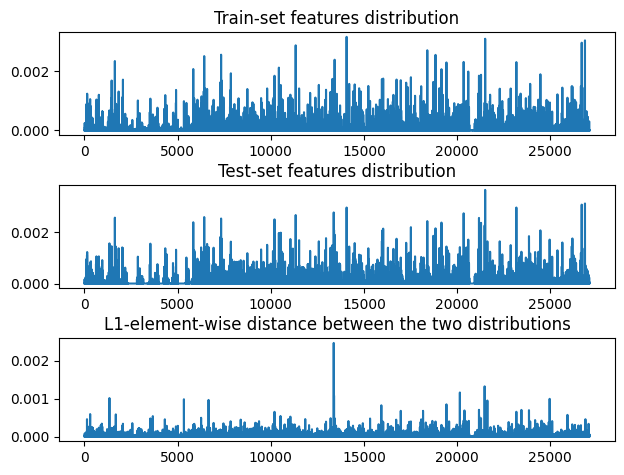

In [153]:
fig, (ng1, ng2, ng3) = plt.subplots(3,1)

fig.tight_layout(pad=1.5)

ng1.plot(training_fe_distro)
ng1.title.set_text('Train-set features distribution')
ng2.plot(test_fe_distro)
ng2.title.set_text('Test-set features distribution')
ng3.plot(np.abs(training_fe_distro-test_fe_distro))
ng3.title.set_text('L1-element-wise distance between the two distributions')

From a data visualization perspective it may seems that the two distribution are pretty close, so we are not skewing toward the supposed-worst-scenario. At the same time it's hard to make a good analysis from just visualization because of the high dimensional framework, so we are also going to compute a metric.

We are going to compute the Jensen-Shannon divergence for these two distributions, which is derived from Kullback–Leibler divergence. This last one basically measures cross-entropy between the distributions:

\begin{align}
D_{KL}(P||Q) = \sum_{x \in X} P(x)log(\frac{P(x)}{Q(x)}) \\
D_{KL}(Q||P) = \sum_{x \in X} Q(x)log(\frac{Q(x)}{P(x)}) 
\end{align}

It is not a metric, because it doesn't ensure simmetry and triangle inequality. The Jensen-Shannon divergence is just a 'correction' of this divergence:

\begin{align}
D_{JS} = \frac{1}{2} D_{KL}(P||Q) + \frac{1}{2} D_{KL}(Q||P)
\end{align}

This metric is good to study distance between a measure distribution and its approximation, especially in high-dimensional framework: in a way this can be extended to training and test feature distribution to evaluate their exchangeability. We want this value to be close to zero.
 

In [64]:
d_kl_pq = 0
d_kl_qp = 0
for id in range(len(vocabulary)):
    if training_fe_distro[id] != 0 and test_fe_distro[id] != 0:                            #Just to work in a 'space' where we don't have inf values in log
        d_kl_pq += training_fe_distro[id]*np.log(training_fe_distro[id]/test_fe_distro[id])
        d_kl_qp += test_fe_distro[id]*np.log(test_fe_distro[id]/training_fe_distro[id])
d_js = 0.5*d_kl_pq + 0.5*d_kl_qp

print('The Jensen-Shannon divergence between training-set and test-set is', d_js)

The Jensen-Shannon divergence between training-set and test-set is 0.11689030330923898


This value of Jensen-Shannon divergence suggests that the distribution of the features in the training-set is pretty similar to the one in the test-set, so the suggested splitting is actually a good one. 

##### 2.3.1.2 Ground truth distribution between training set and test set: evaluating precision and recall distortion

Just to complete our overview, we may have a look to the ground truth distribution in the splitted set.

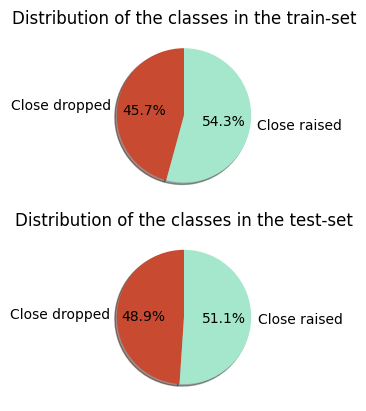

In [30]:
sizes1 = np.array([len(train_set[train_set['Label'] == 0]), len(train_set[train_set['Label'] == 1])])
sizes1 = sizes1/len(train_set)

sizes2 = np.array([len(test_set[test_set['Label'] == 0]), len(test_set[test_set['Label'] == 1])])
sizes2 = sizes2/len(test_set)

classes = ['Close dropped', 'Close raised']

ax1 = plt.subplot2grid((2,1),(0,0))
plt.pie(sizes1, labels=classes,autopct='%1.1f%%',shadow=True, startangle=90, colors=['#C84B31','#A5E7CC'] )
plt.title('Distribution of the classes in the train-set')
ax1 = plt.subplot2grid((2,1),(1,0))
plt.pie(sizes2, labels=classes,autopct='%1.1f%%',shadow=True, startangle=90, colors=['#C84B31','#A5E7CC'] )
plt.title('Distribution of the classes in the test-set')
plt.show()

The test-set is very well balanced, and so is the train-set. The reason between the strange values in precision for Naive Bayes classifier is maybe in a mistake in the implementation, since we implemented the metrics from scratch.

### 3. Model engineering

We tried different models on our extracted features:
- Fully connected network to perform logistic regression both on unigrams and bigrams in PyTorch framework;
- Naive Bayes classifier both on unigrams and bigrams;
- Linear Discriminant Analysis for sentiment analysis. 

Here we are summarising the focal points of each model. 

#### 3.1 Fully connected network in PyTorch

Since we worked on from-scratch implementation in the assignments, we thought that this could be a good opportunity to get familiar with PyTorch. 

In order to correctly set a PyTorch framework, we define some standard tools and steps:
1) First of all we need to convert our vectorized features in *tensors*;
2) Then we need a *DataBuilder* to make the input digestible by the neural network;
3) The *NewsClassifier* is the class that defines our fully connected neural network;
4) It's time for the *training* process;
5) Finally, the evaluation of the model. 

##### 3.1.1 Converting the features in tensors

We are only converting TFIDF vectorized documents in tensors.

In [67]:
final_dataset['TFIDFTensor'] = final_dataset['TFIDF'].apply(lambda x: trc.tensor(x, dtype=trc.float32))
train_set['TFIDFTensor'] = train_set['TFIDF'].apply(lambda x: trc.tensor(x, dtype=trc.float32))
test_set['TFIDFTensor'] = test_set['TFIDF'].apply(lambda x: trc.tensor(x, dtype=trc.float32))
validation_set['TFIDFTensor'] = validation_set['TFIDF'].apply(lambda x: trc.tensor(x, dtype=trc.float32))

##### 3.1.2 *Databuilder* class

In [68]:
class DataBuilder(Dataset):
    def __init__(self, X_data, y_data):
        self.n_samples = len(X_data)
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__(self):
        return self.n_samples 

In [69]:
train = DataBuilder(train_set['TFIDFTensor'], train_set['Label'])
test = DataBuilder(test_set['TFIDFTensor'], test_set['Label'])
validation = DataBuilder(validation_set['TFIDFTensor'], validation_set['Label'])

##### 3.1.3 *NewsClassifier* class

There are two methods in this class:
- `__init__` is the class-builder pointing the superclass `Module` imported from Torch. This method defines a fully connected network with an input linear layer and a hidden linear layer to deal with the high dimensional sparsity.
- `forward` feeds the downstream network, using the `ReLu` activation function between the linear layers and the `Sigmoid` activation function to deal with the binary classification problem.

In [156]:
class NewsClassifier(Module):
    def __init__(self, input_size, hidden_size):
        super(NewsClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lin1 = Linear(self.input_size, self.hidden_size)
        self.lin2 = Linear(self.hidden_size, 1)

    def forward (self, x):
        x = self.lin1(x)
        x = func.relu(x)
        x = self.lin2(x)

        output = trc.sigmoid(x)
        return output     

We decided for a mini-batch gradient descent and made some experiments for a small hold-out validation:
- 10000 neurons in the hidden layer, lr = .001, batch size = 50
    - Accuracy is: 0.5026455026455027
    - Precision is 0.5081967213114754
    - Recall is 0.8031088082901554
    - 5 min 50 seconds for 25 epochs
- 5000 neurons in the hidden layer, lr = .001, batch size = 50
    - Accuracy is: 0.4973544973544973
    - Precision is 0.504885993485342
    - Recall is 0.8031088082901554
    - 2 min 30 seconds for 25 epochs
- 2500 neurons in the hidden layer, lr = .01, batch size = 50
    - Accuracy is: 0.5026455026455027
    - Precision is 0.5100401606425703
    - Recall is 0.6580310880829016
    - 1 min 30 seconds for 25 epochs

Then we made the actual train with the chosen parameters with a batch-gradient descent approach. 

##### 3.1.4 Actual training loop

In [ ]:
model = NewsClassifier(len(vocabulary), 2500)                                           #Defining an istance of the model
optimizer_batch = trc.optim.Adam(model.parameters(), lr=0.01)                           #Choosing the optimizer and the learning rate
criterion = trc.nn.BCELoss()                                                            #Binary Cross-entropy is the standard for binary classification

bsize = train.__len__()                                                                 #Defining the dimension of the mini batch
train_loaded = DataLoader(dataset=train, batch_size=bsize)                              #Dataloader is a standard tool in PyTorch to load the data

loss_list = []                                                                          #Initializing records for the losses
avg_loss_list = []
n_epochs = 50                                                                           #Setting the number of epochs

for epoch in range(1,n_epochs):                                                         #Training loop
  losses = []
  for X_batch, y_batch in train_loaded:                                                 #Inner training loop 
      optimizer_batch.zero_grad()                                                       #Reinitializes gradients at each iteration
      prediction = model.forward(X_batch)                                               #Feeding the downstream network
      loss = criterion(prediction, trc.reshape(y_batch, (len(prediction),1)).float())   #Computing the loss
      loss.backward()                                                                   #Upstream gradients
      optimizer_batch.step()                                                            #Update parameters
      losses.append(loss.item())      
      print('\repoch: {}\tLoss =  {:.3f}'.format(epoch, loss), end='')
  loss_list += losses
  avg_loss_list.append(sum(losses)/len(losses))
  print('\n')

Text(0.5, 1.0, 'Training loss')

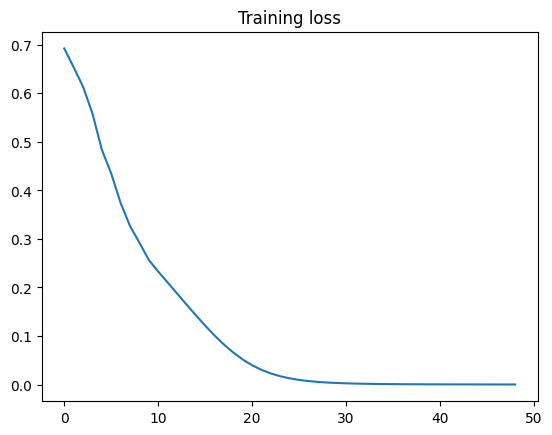

In [175]:
plt.plot(avg_loss_list)
plt.title('Training loss')

##### 3.1.5 Prediction and evaluation 

In [170]:
test_loaded = DataLoader(dataset=test)
matrix = np.zeros((2,2),dtype=np.int64)
tp = 0
tn = 0
fn = 0
fp = 0  
for X_batch, y_batch in test_loaded:  
    prediction = model.forward(X_batch)
    if prediction > 0.5: 
        prediction = 1
    else:
        prediction = 0
    if trc.tensor(prediction) == 1 and y_batch[0] == 1:
        tp += 1
    elif trc.tensor(prediction) == 1 and y_batch[0] == 0:
        fp += 1
    elif trc.tensor(prediction) == 0 and y_batch[0] == 1:
        fn += 1
    elif trc.tensor(prediction) == 0 and y_batch[0] == 0:
        tn += 1
matrix[0,0]=tn
matrix[0,1]=fp
matrix[1,0]=fn
matrix[1,1]=tp
print(matrix)

[[ 35 150]
 [ 28 165]]


In [171]:
print('Accuracy is:', (matrix[0,0]+matrix[1,1])/test.__len__())
print('Precision is', (matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Recall is', (matrix[1,1]/(matrix[1,0]+matrix[1,1])))

Accuracy is: 0.5291005291005291
Precision is 0.5238095238095238
Recall is 0.8549222797927462


#### 3.2 Naive Bayes classifier

This is our implementation from scratch for Naive Bayes classifier. 
- `__init__` initializes the istance of the class setting its main parameters;
- `fit` method computes the Naive Bayes maximum likelihood estimators based on some inputs, recording them in the method parameters;
- `predict` method outputs the predicted label for some input data based on the fitting the classifier did on the train set. 

In [243]:
class NBFS:
    def __init__(self, k = 1):                                                              #k is a parameter to perform Laplace smoothing and fight 
        self.k = k                                                                          #high-dimensional sparsity
        self.classes = None
        self.class_priors = None
        self.feature_probs = None

    def fit(self, X_train, y_train):
        n_samples, n_features = X_train.shape
        self.classes = np.unique(y_train)
        n_classes = len(self.classes)

        self.class_priors = np.zeros(n_classes)
        for i, c in enumerate(self.classes):
            self.class_priors[i] = np.sum(y_train == c)/n_samples

        self.feature_probs = np.zeros((n_classes, n_features))
        for i, c in enumerate(self.classes):
            X_c = X_train[y_train == c]
            self.feature_probs[i] = (np.sum(X_c, axis=0) + self.k)/(np.sum(X_c) + self.k*n_classes)   #Laplace smoothing is here

    def predict(self, X_test):
        n_samples = X_test.shape[0]
        y_pred = np.zeros(n_samples)
        for i in range(n_samples):
            posteriors = []
            for j, c in enumerate(self.classes):
                prior = np.log(self.class_priors[j])                                        #Log and sum to reduce computational effort
                likelihood = np.sum(np.log(self.feature_probs[j]) * X_test[i])
                posterior = prior + likelihood
                posteriors.append(posterior)
            y_pred[i] = self.classes[np.argmax(posteriors)]
        return y_pred

This is the metrics implementation that distorted the precision during the final presentation: there was an error with the call of `confusion_matrix` that has been solved.

In [244]:
def confusion_matrix(y_t,y_p):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for true, predicted in zip(y_t, y_p):
        if true == 1 and predicted == 1:
            tp += 1
        elif true == 1 and predicted == 0:
            fn += 1
        elif true == 0 and predicted == 1:
            fp += 1
        else:
            tn += 1
    return {'TP':tp, 'TN':tn, 'FN':fn, 'FP':fp}

def metrics(y_t,y_p):
    cf = confusion_matrix(y_t, y_p)
    accuracy = (cf['TP']+cf['TN'])/sum(cf.values())
    precision = cf['TP']/(cf['TP']+cf['FP'])
    recall = cf['TP']/(cf['TP']+cf['FN'])
    return {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall}

Then we just compared our implementation with the scikit learn one. Since we decided for a Bernoulli Naive Bayes, we used the one-hot vectorization of the documents as the input features.

In [245]:
X_train = np.array(train_set['OneHot'].to_list())
y_train = np.array(train_set['Label'].to_list())

X_test = np.array(test_set['OneHot'].to_list())
y_test = np.array(test_set['Label'].to_list())

bnb_sk = BernoulliNB()
bnb_sk.fit(X_train,y_train)
predictions = bnb_sk.predict(X_test)
print("Scores of scikit-Bernoulli-Naive-Bayes",metrics(y_test,predictions))

bnb_fs = NBFS()
bnb_fs.fit(X_train,y_train)
predictions = bnb_fs.predict(X_train)
print("Scores of from-scratch-Bernoulli-Naive-Bayes",metrics(y_test,predictions))

Scores of scikit-Bernoulli-Naive-Bayes {'Accuracy': 0.48677248677248675, 'Precision': 0.49834983498349833, 'Recall': 0.7823834196891192}
Scores of from-scratch-Bernoulli-Naive-Bayes {'Accuracy': 0.5291005291005291, 'Precision': 0.5358851674641149, 'Recall': 0.5803108808290155}


#### 3.3 Linear Discriminant Analysis for sentiment analysis

##### 3.3.1 Preprocessing and feature extraction

This model actually needs a different feature engineering, extracting subjectivity and polarity from documents. In order to do this, we firstly have to convert preprocessed news into strings.

In [248]:
#converting the words into a list of lists
preprocessed_news_text = final_dataset["Preprocessed News"].values.tolist()

#converting the lists into string to obtain the text
preprocessed_news_text_ = [" ".join(news) for news in preprocessed_news_text]

#converting the final list into a DataFrame
df_string_news = pd.DataFrame(preprocessed_news_text_, columns = ['Preprocessed News Text'])

#Saving the index as a column to merge the two DataFrames
final_dataset.reset_index(inplace=True)
df_string_news.reset_index(inplace=True)

#Merge to obtain the final DataFrame
final_dataset_text = final_dataset.merge(df_string_news, left_on='index', right_on='index')

#Getting just the useful columns
final_dataset_text = final_dataset_text.drop(columns=['Preprocessed News','index', 'TFIDF','OneHot'])

Our motivation for conducting sentiment-based text analysis, or opinion mining as it is commonly known, is to determine how neutral the media are in reporting the news and how this neutrality or non-neutrality affects the stock price. 

Sentiment Analisys can help us to determine the mood or emotion in a text. This type of analysis is used to have a better understanding of the text and with this to analyze the impacts they cause.

Firstly, we are going to use TextBlob that is a library for Natural Language Processing(NLP) which performs complex analysis on data. This library use NLTK.
TextBlob will give us back a score of polarity and subjectivity of the text.



- Polarity score will be between -1 and 1, where -1 is a text considered negative and 1 is a text considered positive. In this case -1 will be for bad news and 1 for good news. 
- Subjectivity takes into account the personal and objective opinion contained in the text. Subjectivity score will be between 0 and 1, the closer to 1 the subjectivity is, it implies that the text contains more personal opinion than factual information.

Secondly, we are going to use VADER (Valence Aware Dictionary and sEntiment Reasoner) to obtain the score that represents whether the news is qualified as negative, positive, or neutral. VADER is a rule-based model for sentiment analysys specialized in social media. Several studies have shown that VADER is more sensitive for social media text analysis compared to other models. VADER also takes into consideration word order and degree modifiers <sup>[3]</sup>. 

In [249]:
final_dataset_text.head(10)

,level_0,Date,Label,Preprocessed News Text
0,0,2016-07-01,1,woman mexico citi final receiv birth certif di...
1,1,2016-06-30,1,jamaica propos marijuana dispens tourist airpo...
2,2,2016-06-29,1,explos airport istanbul yemeni former presid t...
3,3,2016-06-28,1,scientist australia want save great barrier re...
4,4,2016-06-27,0,barclay share suspend trade tank pope say chur...
5,5,2016-06-24,0,david cameron resign referendum forecast vote ...
6,6,2016-06-23,1,today unit kingdom decid whether remain europe...
7,7,2016-06-22,0,german govern agre frack indefinit teenag recr...
8,8,2016-06-21,1,australian athlet compet paralymp game rob gun...
9,9,2016-06-20,1,stagger percent venezuelan money enough food c...


In [250]:
def subjectivity_score(news):
    return TextBlob(news).sentiment.subjectivity

def polarity_score(news):
    return TextBlob(news).sentiment.polarity

final_dataset_text["Subjectivity"] = final_dataset_text["Preprocessed News Text"].apply(subjectivity_score)
final_dataset_text["Polarity"] = final_dataset_text["Preprocessed News Text"].apply(polarity_score)

In [251]:
final_dataset_text.sort_values(by="Subjectivity", ascending=False).head(10)

,level_0,Date,Label,Preprocessed News Text,Subjectivity,Polarity
1909,1909,2008-12-01,0,bthe make offenc punish year imprison publish ...,0.750000,0.109524
1924,1924,2008-11-07,1,judg ask media whether releas guantanamo tortu...,0.696984,-0.005450
1238,1238,2011-08-01,0,murdoch news intern order tech firm massdelet ...,0.627778,-0.252083
1774,1774,2009-06-16,0,byall femin patriot iranian woman million prot...,0.605556,-0.167187
1986,1986,2008-08-12,0,brememb ador sang open ceremoni fake brussia e...,0.600140,-0.214076
1644,1644,2009-12-18,1,bpragu tower world largest spheric rnpanorama ...,0.590196,-0.031194
1933,1933,2008-10-27,0,bbbc rampant evid georgia commit crime conflic...,0.579630,-0.150463
1336,1336,2011-03-11,1,massiv earthquak northeastern japan someon pos...,0.573611,0.290278
324,324,2015-03-20,1,franc decre rooftop must cover plant solar pan...,0.566821,0.042675
738,738,2013-07-29,0,saudi princ defect royal famili regim saudi ar...,0.561458,-0.052083


In [252]:
final_dataset_text.sort_values(by="Polarity", ascending=True).head(10)

,level_0,Date,Label,Preprocessed News Text,Subjectivity,Polarity
1555,1555,2010-04-29,1,bchina lost olymp bronz medal gymnast proven u...,0.451282,-0.287179
1238,1238,2011-08-01,0,murdoch news intern order tech firm massdelet ...,0.627778,-0.252083
1899,1899,2008-12-15,0,bturk apolog armenian massacr bgreek youth bre...,0.538095,-0.233929
661,661,2013-11-14,1,indian train strike herd eleph cross track inc...,0.420333,-0.233667
1957,1957,2008-09-23,0,billion money alloc reconstruct project iraq w...,0.528571,-0.228571
1986,1986,2008-08-12,0,brememb ador sang open ceremoni fake brussia e...,0.600140,-0.214076
1779,1779,2009-06-09,0,bwont reddit think bthe puzzl crash franc flig...,0.347194,-0.196854
1978,1978,2008-08-22,1,bsyria say readi russian missil system soil co...,0.315799,-0.196007
1894,1894,2008-12-22,0,bman threaten arrest australian antiterror vid...,0.322685,-0.186420
1893,1893,2008-12-23,0,bamerican express get billion capit get billio...,0.313403,-0.182847


By organizing the data in ascending order with respect to Polarity, it is possible to see in the first 10 data a relationship between Subjectivity, Polarity and the Label, which is our value of interest. 

As evidenced above, when the Polarity score is negative, that is, it tends to be negative news, and the Subjectivity value is close to 0.5 or higher, which means that the news tends to be subjective, the stock price had a decrease. This analysis is done a priori of the model to show that a logical relationship between the variables exists and therefore, we can have good results with the prediction model.

#### 3.3.2 Sentiment Analysis using VADER

`SentimentIntensityAnalyzer` is an object and `polarity_scores` is a method that returns the following scores:
- Positive
- Negative
- Neutral
- Compound

Compound score refers to the sum of positive, negative and neutral scores which is going to be between -1 and 1, -1 to extreme negative and 1 to extreme positive.

In [255]:
def sentiment_score(news):
    sentiment_fun= SentimentIntensityAnalyzer()
    sentiment_value = sentiment_fun.polarity_scores(news)
    return sentiment_value 

#Creating lists to save each score
positive = []
negative = []
neutral = []
compound = []

#Applying the funcion to the news.
for news in range (0, len(final_dataset_text["Preprocessed News Text"])):
    sentiment_analysis = sentiment_score(final_dataset_text["Preprocessed News Text"][news])
    positive.append(sentiment_analysis['pos'])
    negative.append(sentiment_analysis['neg'])
    neutral.append(sentiment_analysis['neu'])
    compound.append(sentiment_analysis['compound'])

In [256]:
final_dataset_text['Positive'] = positive
final_dataset_text['Negative'] = negative
final_dataset_text['Neutral'] = neutral
final_dataset_text['Compound'] = compound

In [257]:
final_dataset_text.loc[final_dataset_text['Label']==1].sort_values(by="Compound", ascending=False)

,level_0,Date,Label,Preprocessed News Text,Subjectivity,Polarity,Positive,Negative,Neutral,Compound
1262,1262,2011-06-27,1,video smuggl north korea children beg armi sta...,0.278611,-0.005833,0.097,0.076,0.828,0.7971
1974,1974,2008-08-28,1,bmilitari help georgia declar say moscow bwest...,0.169271,0.010938,0.139,0.106,0.755,0.7906
1203,1203,2011-09-20,1,itali propos peopl internet base singl accus i...,0.413333,0.028333,0.111,0.092,0.797,0.7757
410,410,2014-11-13,1,european robot probe phila made first histor l...,0.358506,0.032299,0.104,0.077,0.820,0.7579
749,749,2013-07-12,1,canadian dollar prize first human power helico...,0.335073,0.115959,0.123,0.109,0.768,0.7176
...,...,...,...,...,...,...,...,...,...,...
1528,1528,2010-06-08,1,breuter fire remov weapon blood imag gaza flot...,0.340263,-0.043991,0.025,0.286,0.690,-0.9984
373,373,2015-01-08,1,charli hebdo issu come next week hard suffer g...,0.281522,-0.088406,0.042,0.322,0.636,-0.9984
989,989,2012-07-26,1,french presid francoi holland call percent inc...,0.280000,-0.034167,0.061,0.301,0.638,-0.9984
1761,1761,2009-07-06,1,buganda outlaw femal circumcis bbreak news kil...,0.317778,-0.108687,0.020,0.378,0.601,-0.9985


In [258]:
final_dataset_text.loc[final_dataset_text['Label']==0].sort_values(by="Compound", ascending=False)

,level_0,Date,Label,Preprocessed News Text,Subjectivity,Polarity,Positive,Negative,Neutral,Compound
1686,1686,2009-10-20,0,blegal lobbi grow mexico latin american countr...,0.419048,0.108874,0.172,0.100,0.729,0.9493
1408,1408,2010-11-26,0,didnt understand quit thing becom countri arm ...,0.408986,0.163248,0.152,0.110,0.738,0.9140
421,421,2014-10-29,0,time nation urg embargo cuba scientist discov ...,0.412952,0.127121,0.123,0.098,0.779,0.9001
325,325,2015-03-19,0,alzheim treatment fulli restor memori function...,0.271325,0.126734,0.109,0.077,0.815,0.8074
430,430,2014-10-16,0,wind blow away fossil power nordic baltic next...,0.350784,-0.050784,0.120,0.093,0.787,0.8023
...,...,...,...,...,...,...,...,...,...,...
71,71,2016-03-22,0,intern crimin court recognis rape crime former...,0.377833,0.142245,0.052,0.345,0.603,-0.9982
1238,1238,2011-08-01,0,murdoch news intern order tech firm massdelet ...,0.627778,-0.252083,0.045,0.329,0.627,-0.9983
964,964,2012-08-30,0,south african miner arrest protest charg murde...,0.292857,-0.047024,0.065,0.300,0.635,-0.9984
622,622,2014-01-13,0,broad coalit wellknown organ reddit electron f...,0.298106,0.044571,0.077,0.309,0.614,-0.9985


As expected, in a general view, when the polarity values ​​are negative, the Compound values ​​are also negative indicating that it is bad news and vice versa.

Finally, we save the relevant features of the DataFrame

In [260]:
final_dataset_text = final_dataset_text[['Label','Subjectivity','Polarity','Positive','Negative','Neutral','Compound']]
final_dataset_text.head(10)

,Label,Subjectivity,Polarity,Positive,Negative,Neutral,Compound
0,1,0.315284,0.049693,0.047,0.271,0.681,-0.9981
1,1,0.381366,-0.048344,0.079,0.251,0.671,-0.9966
2,1,0.263571,0.142857,0.105,0.169,0.726,-0.9545
3,1,0.308703,0.038013,0.112,0.108,0.780,0.0516
4,0,0.214222,-0.028389,0.083,0.152,0.765,-0.9612
5,0,0.246939,0.056859,0.065,0.109,0.825,-0.8519
6,1,0.213095,0.028175,0.068,0.182,0.750,-0.9871
7,0,0.193116,0.016787,0.068,0.128,0.804,-0.9761
8,1,0.200000,0.004500,0.073,0.245,0.682,-0.9971
9,1,0.376912,0.099639,0.058,0.252,0.690,-0.9980


##### 3.3.3 Linear discriminant analysis

Linear Discriminant Analysis (LDA) is a method from multivariate statistics which principal objective is to find a
linear projection of high-dimensional observations into a lower-dimensional space. When your preconditions are met, LDA allows you to define optimal linear decision bounds on the
resulting latent space <sup>[4]</sup>.

In other words, Linear Discriminant Analysis is a linear classification algorithm, like logistic regression. The algorithm develops a probabilistic model by class based on the distribution of observations for each input variable [5]. 

In this way, the data is classified by getting the conditional probability of it belonging to each class and the class with the highest probability is chosen. This means that LDA can be considered as an application of the Bayes Theorem for classification. 

This model assumes that the input variables are numeric, normally distributed and that they have the same variance. Also, it assumes that the input variables are not correlated. Therefore, this model makes strong assumptions about the distribution of each input variable.

LDA is naturally multi-class, so it supports two-class classification problems, such as our case of study.

Our motivation in selecting this simple model is to analyze the behavior and the results obtained from it after making all the assumptions described above and reinforcing the adjustment of the hyperparameters with PCA (to reduce dimensionality and correlation) and cross validation.


In [ ]:
X = final_dataset_text
X = np.array(X.drop(['Label'], 1))

y = np.array(final_dataset_text['Label'])

Standarization of the dataset is a common requirment to for modeling the data. In the case of LDA it is not necessary because LDA results will be the same whether or not the data is standardized. However, it is a good practice to do it in the pre-processing data of a model which assumes that its features have a Gaussian distribution.

In [ ]:
x_scaled = StandardScaler().fit_transform(X)

In [262]:
#Reducing the number of features to 4 
pca = PCA(n_components=4)

#Fit the model 
pca_features = pca.fit_transform(x_scaled)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [263]:
pca_df['Label'] = y

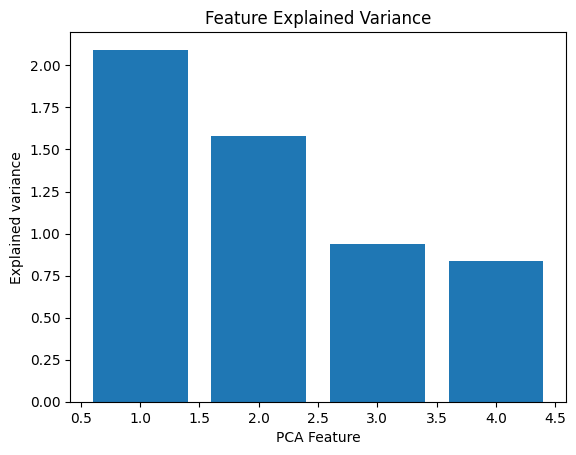

In [264]:
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

As evidenced in the figure obtained, the PC3 and PC4 don't have much relevance in the target. Since we know that LDA is also a dimensionality reducer, we jointly define leaving all the features obtained and performing the LDA with them.

In [265]:
model_1 = LinearDiscriminantAnalysis() #create the model for data with PCA applied
model_1.fit(pca_features, y)

model_2 =  LinearDiscriminantAnalysis() #create the model for data without PCA applied
model_2.fit(x_scaled, y)

LinearDiscriminantAnalysis()

In [268]:
#Evaluation method
cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluating the model
acc = cross_val_score(model_1, pca_features, y, scoring='accuracy', cv=cross_validation, n_jobs=-1)
pre = cross_val_score(model_1, pca_features, y, scoring='precision', cv=cross_validation, n_jobs=-1)
rec = cross_val_score(model_1, pca_features, y, scoring='recall', cv=cross_validation, n_jobs=-1)


#Result
print('Model Mean Accuracy: %.3f (%.3f)' % (np.mean(acc), np.std(acc)))
print('Model Mean Precision: %.3f (%.3f)' % (np.mean(pre), np.std(pre)))
print('Model Mean Recall: %.3f (%.3f)' % (np.mean(rec), np.std(rec)))

Model Mean Accuracy: 0.530 (0.013)
Model Mean Precision: 0.534 (0.006)
Model Mean Recall: 0.982 (0.027)


In [269]:
#Evaluation method
cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#Evaluating the model
acc = cross_val_score(model_2, x_scaled, y, scoring='accuracy', cv=cross_validation, n_jobs=1)
pre = cross_val_score(model_2, x_scaled, y, scoring='precision', cv=cross_validation, n_jobs=1)
rec = cross_val_score(model_2, x_scaled, y, scoring='recall', cv=cross_validation, n_jobs=1)


#Result
print('Model Mean Accuracy: %.3f (%.3f)' % (np.mean(acc), np.std(acc)))
print('Model Mean Precision: %.3f (%.3f)' % (np.mean(pre), np.std(pre)))
print('Model Mean Recall: %.3f (%.3f)' % (np.mean(rec), np.std(rec)))


Model Mean Accuracy: 0.532 (0.013)
Model Mean Precision: 0.535 (0.007)
Model Mean Recall: 0.975 (0.030)


We can see that the model performance are very similar wheter the PCA is performed or not. 

### 4. Analysis 

#### 4.1 A state-of-art reference for accuracy

![State of art](https://admhw3.s3.amazonaws.com/stateofart.jpg "State of art")

This table comes from the benchmark from a paper<sup>[5]</sup> describing a work that is very close to ours. The main differences are:
- The adopted textual datasets is a collection of financial reports;
- The feature engineering contemplate miscellanous inputs. 

As we can see the accuracy score that is the more related to our work is the one extracted from the performances of the unigram model, and it is pretty close to our top performances. These low values for accuracy are surely related to the high complexity of the considered phenomenon.

#### 4.2 Our benchmark 

We are only considering the unigrams feature engineering.

| Model                        | Accuracy   | Precision   |Recall             |
| ---------------------------- | -----------| ------------|-------------------|
| Fully connected NN           | 0.52910    | 0.52381     |0.85492            |
| Naive Bayes from-scratch     | 0.52910    | 0.53589     |0.58031            |
| Naive Bayes scikit           | 0.48678    | 0.49835     |0.78238            |
| Linear Discriminant Analysis | 0.53200    | 0.53500     |0.97500            |

As we can see the dataset is quiet robust to the different classification models. The performances strongly discourage from taking part in the tricky world of trading, but for sure our model can be improved. In particular:
- We may pay more attention to regularization tools;
- We may improve the feature engineering with more advanced model that can explain the complexity of the problem way better.

### 5. Future works

1) Including other financial features: the volume of transictions is crucial about the health state of the stock market.
2) Multinomial classification defining more complex labels, with respect to the range of the variation. 0-class is no change, 1-class is small negative change, 2-class is meltdown, 3-class is small positive change, 4-class is a glorious day for stock market. We can define this new labels with respect to the distribution of the variations between subsequent closing indeces. 
3) Feature extraction that highlights the localty of some recurrent patterns (concept based model, pattern based model<sup>[6]</sup>) to leverage powerful convulational neural network
4) Building a end-to-end application with a user interface to allow the user to make his own predictions.

### 6. References

<sup>[1]</sup> https://www.bmo.com/main/personal/investments/learning-centre/how-breaking-news-affects-markets/

<sup>[2]</sup> 'Text mining approaches for stock market prediction' A.Nikfarja, E.Emadzadeh, S.Muthaiyah

<sup>[3]</sup> ['Twitter Sentiment Analysis Using Natural Language Toolkit and VADER Sentiment'](https://www.iaeng.org/publication/IMECS2019/IMECS2019_pp12-16.pdf), Shihab Elbagir and Jing Yang,*Proceedings of the International MultiConference of Engineers and Computer Scientists 2019
IMECS 2019, March 13-15, 2019, Hong Kong*

<sup>[4]</sup> ['Deep linear discriminant analysis'](https://arxiv.org/pdf/1511.04707.pdf),Matthias Dorfer, Rainer Kelz & Gerhard Widmer, *Published as a conference paper at ICLR 2016*

<sup>[5]</sup> ['On the Importance of Text Analysis for Stock Price Prediction'](http://www.lrec-conf.org/proceedings/lrec2014/pdf/1065_Paper.pdf), H.Lee, M.Surdeanu, B.MacCartney, D.Jurafsky

<sup>[6]</sup> ['Text Mining at Feature Level: A Review'](https://media.neliti.com/media/publications/239634-text-mining-at-feature-level-a-review-f97764b6.pdf), T.Shruti, M.Choudhary, *International Journal of Advanced Engineering, Management and Science (IJAEMS) [Vol-2, Issue-9, Sept- 2016]*
